In [ ]:
!pip install deslib
!pip install umap-learn

     |████████████████████████████████| 163kB 29.2MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 1.1MB 31.9MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=b8840e6d00251893265ccac8793ded99db18d695297e650f4e590df4ae937e9e
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.4-cp37-none-any.whl size=52374 sha256=743a06099c7a0ef2af844dcbdda47b45a5797f8cbda3a6cbd693f2176b3eff4b
  Stored in directory: /root/.cache/pip/wheels/42/4b/8c/f6f119c67cf6583bb192431fa8f7278cf95e5b943055077d94
Successfully built umap-learn pynndescent


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from deslib.util.diversity import double_fault, Q_statistic, negative_double_fault
import umap
import matplotlib.lines as mlines
from deslib.util.aggregation import *

In [ ]:
rd = np.random.RandomState(42)

In [ ]:
def calc_delta(labels = {}, pred = {}, clfs=[], function='k', negative=False, inverso=False):
    size = len(clfs)
    delta = np.zeros(shape=(size, size))
    for i, clf1 in enumerate(clfs):
        for k, clf2 in enumerate(clfs):
            if function == 'k':
              delta[i][k] = cohen_kappa_score(labels, pred[clf1], pred[clf2])
            elif function == 'q':
              delta[i][k] = Q_statistic(labels, pred[clf1], pred[clf2])
            else:
              if negative==False:
                if inverso==False:
                  delta[i][k] = double_fault(labels, pred[clf1], pred[clf2])
                else:
                  delta[i][k] = 1/double_fault(labels, pred[clf1], pred[clf2])
              if negative==True:
                delta[i][k] = negative_double_fault(labels, pred[clf1], pred[clf2])
    return delta, clfs


def tsne_full(labels,  delta , title='' , escala=0, size=5, x_ini=0, x_fim=0, y_ini=0, y_fim=0, espacamento=50, per=100 , lern=200.0, iterations=2500, ang=0.5, size_dot=10, cores={}, simbolos={}, tsne=True, neighbors=2):
    if tsne:
      model = TSNE(init='pca', early_exaggeration=espacamento, perplexity=per, learning_rate=lern, random_state=42, n_iter=iterations, angle=ang)
      # new_values = tsne_model.fit_transform(delta)
    else:
      model = umap.UMAP(
          n_neighbors=neighbors,
          min_dist=1,
          n_components=2,
          metric='euclidean',          
          random_state=np.random.RandomState(42)
      )
    new_values = model.fit_transform(delta)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    fig = plt.figure(figsize=(size, size))
    plt.title(title)

    if escala > 0:
        plt.ylim(escala * -1, escala)
        plt.xlim(escala * -1, escala)
    else:
        plt.ylim(y_ini, y_fim)
        plt.xlim(x_ini, x_fim)
    
    dot = 0
    for i in range(len(x)):
        plt.scatter(x[i], y[i], s=size_dot,  marker=simbolos[dot], c=cores[dot])        
        posicao=(5, 8)
        clf_label, sufix_label = labels[i].split("-")[0], labels[i].split("-")[1]
        
        plt.annotate(clf_label, xy=(x[i], y[i]), xytext=posicao, textcoords='offset points', ha='center', va='bottom')  
        dot = dot+1
        if dot == 5:
            dot = 0

    m1 = mlines.Line2D([], [], color=cores[0], marker=simbolos[0], linestyle='None', markersize=10, label='TF')
    m2 = mlines.Line2D([], [], color=cores[1], marker=simbolos[1], linestyle='None', markersize=10, label='TFIDF')
    m3 = mlines.Line2D([], [], color=cores[2], marker=simbolos[2], linestyle='None', markersize=10, label='Word2Vec')
    m4 = mlines.Line2D([], [], color=cores[3], marker=simbolos[3], linestyle='None', markersize=10, label='Glove')
    m5 = mlines.Line2D([], [], color=cores[4], marker=simbolos[4], linestyle='None', markersize=10, label='FastText')
    
    plt.legend(handles=[m1, m2, m3, m4, m5])
    plt.tight_layout()
    plt.savefig('{}.pdf'.format(title), dpi=fig.dpi)  
    # plt.show()
    

#Data

In [ ]:
def load_data(fold, dataset_name):
  if dataset_name == "hateval":
    uri_train   = '/content/drive/MyDrive/Dataset/Folds/hateval/pred_train_hateval.csv'
    uri_val   = '/content/drive/MyDrive/Dataset/Folds/hateval/pred_val_hateval.csv'
    uri_test   = '/content/drive/MyDrive/Dataset/Folds/hateval/pred_test_hateval.csv'

    df_train = pd.read_table(uri_train, sep=',')
    df_val   = pd.read_table(uri_val, sep=',')
    df_test = pd.read_table(uri_test, sep=',')

    val, class_val = df_val.drop(columns=["Unnamed: 0", "HS"]), df_val['HS']
    test, class_test = df_test.drop(columns=["Unnamed: 0", "HS"]), df_test['HS']
  else:
    uri_train   = '/content/drive/MyDrive/Dataset/Folds/{}/{}/pred_train.csv'.format(dataset_name, fold)
    uri_val   = '/content/drive/MyDrive/Dataset/Folds/{}/{}/pred_val.csv'.format(dataset_name, fold)
    uri_test   = '/content/drive/MyDrive/Dataset/Folds/{}/{}/pred_test.csv'.format(dataset_name, fold)

    df_train = pd.read_table(uri_train, sep=',')
    df_val   = pd.read_table(uri_val, sep=',')
    df_test = pd.read_table(uri_test, sep=',')
    

    val, class_val = df_val.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'class']), df_val['class']
    test, class_test = df_test.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'class']), df_test['class']

  return val, class_val, test, class_test

In [ ]:
cores = {}
cores[0] = '#DAA520'
cores[1] = '#FF0000'
cores[2] = '#0000FF'
cores[3] = '#228B22'
cores[4] = '#000000'

simbolos = {}
simbolos[0] = 'X'
simbolos[1] = 'd'
simbolos[2] = '*'
simbolos[3] = "^"
simbolos[4] = 'o'

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


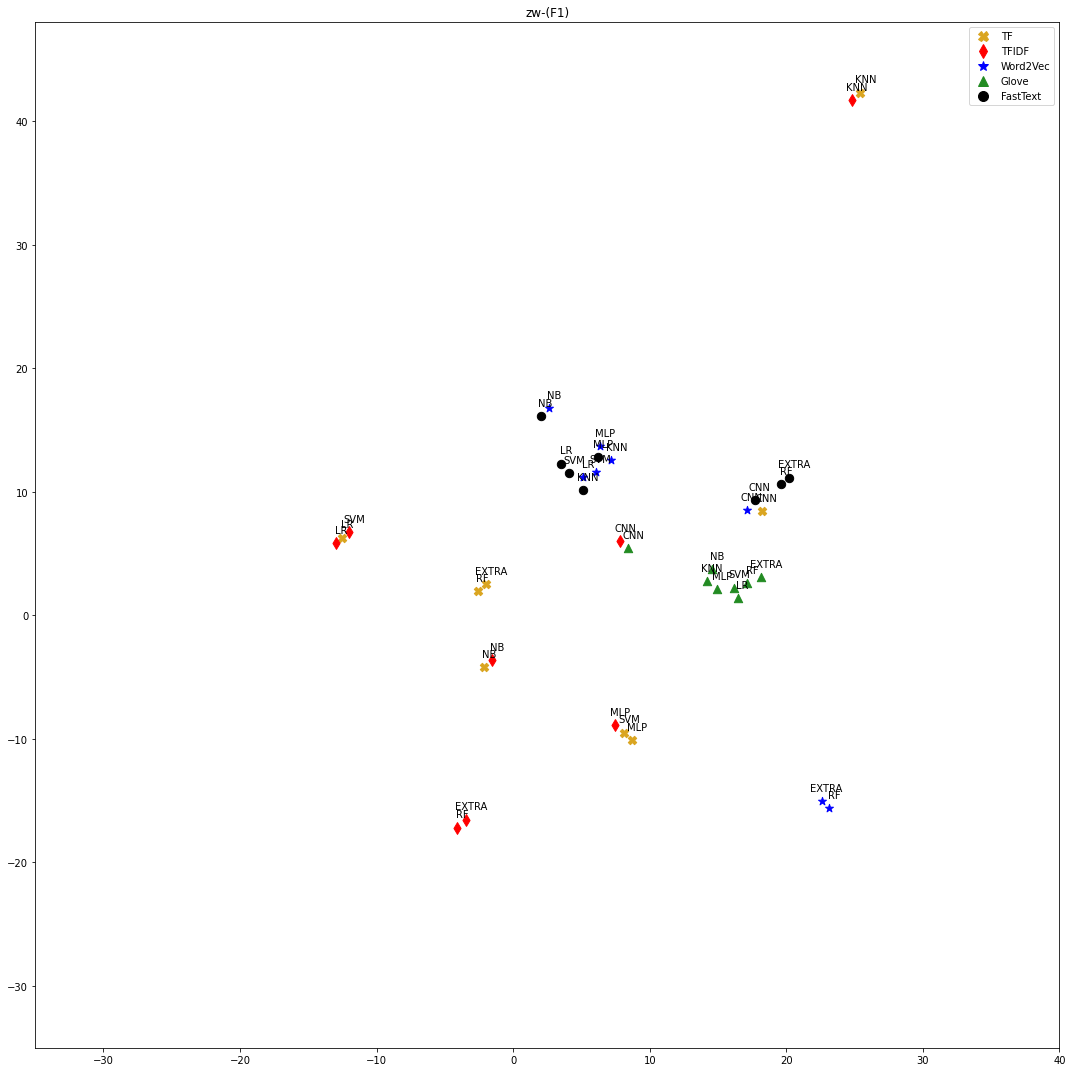

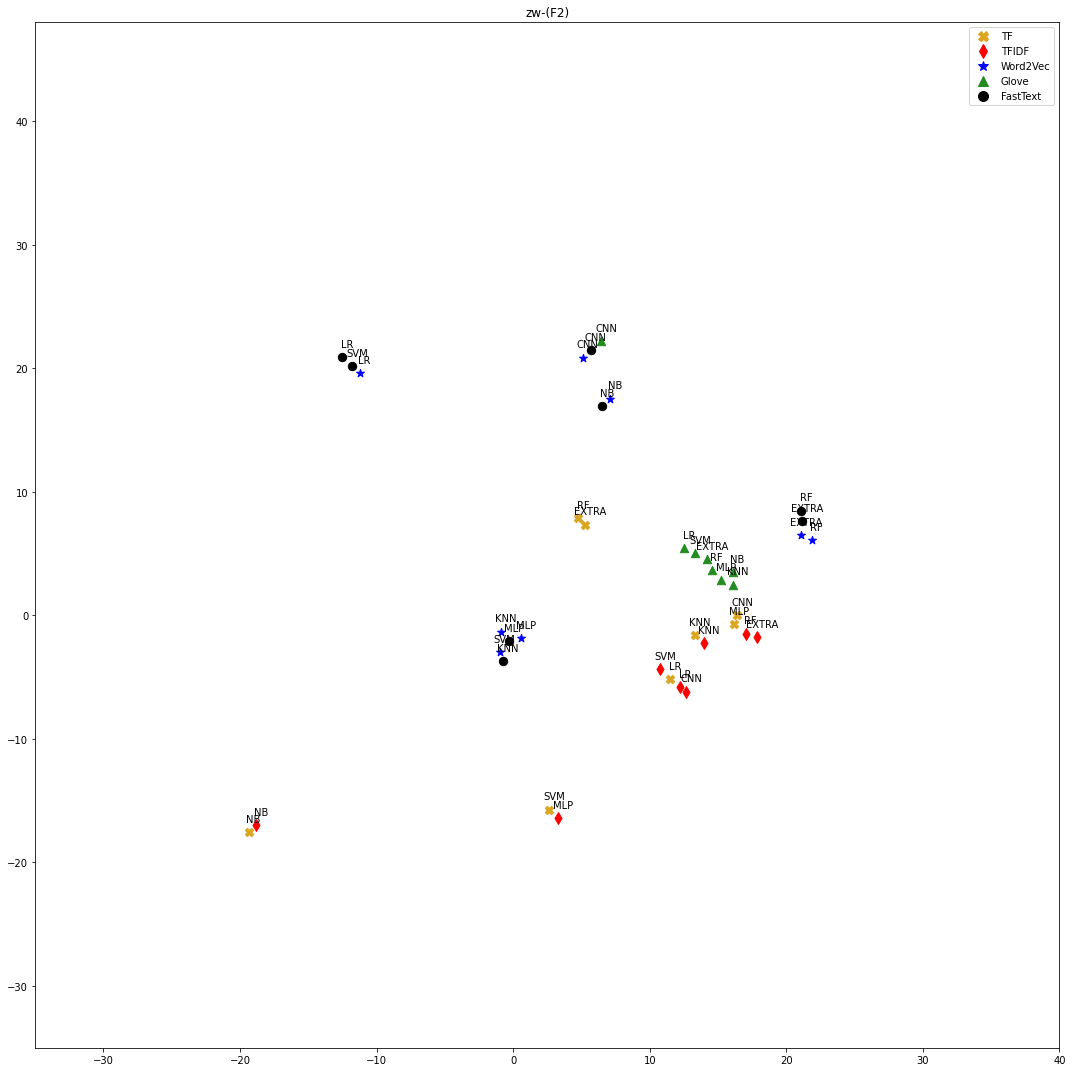

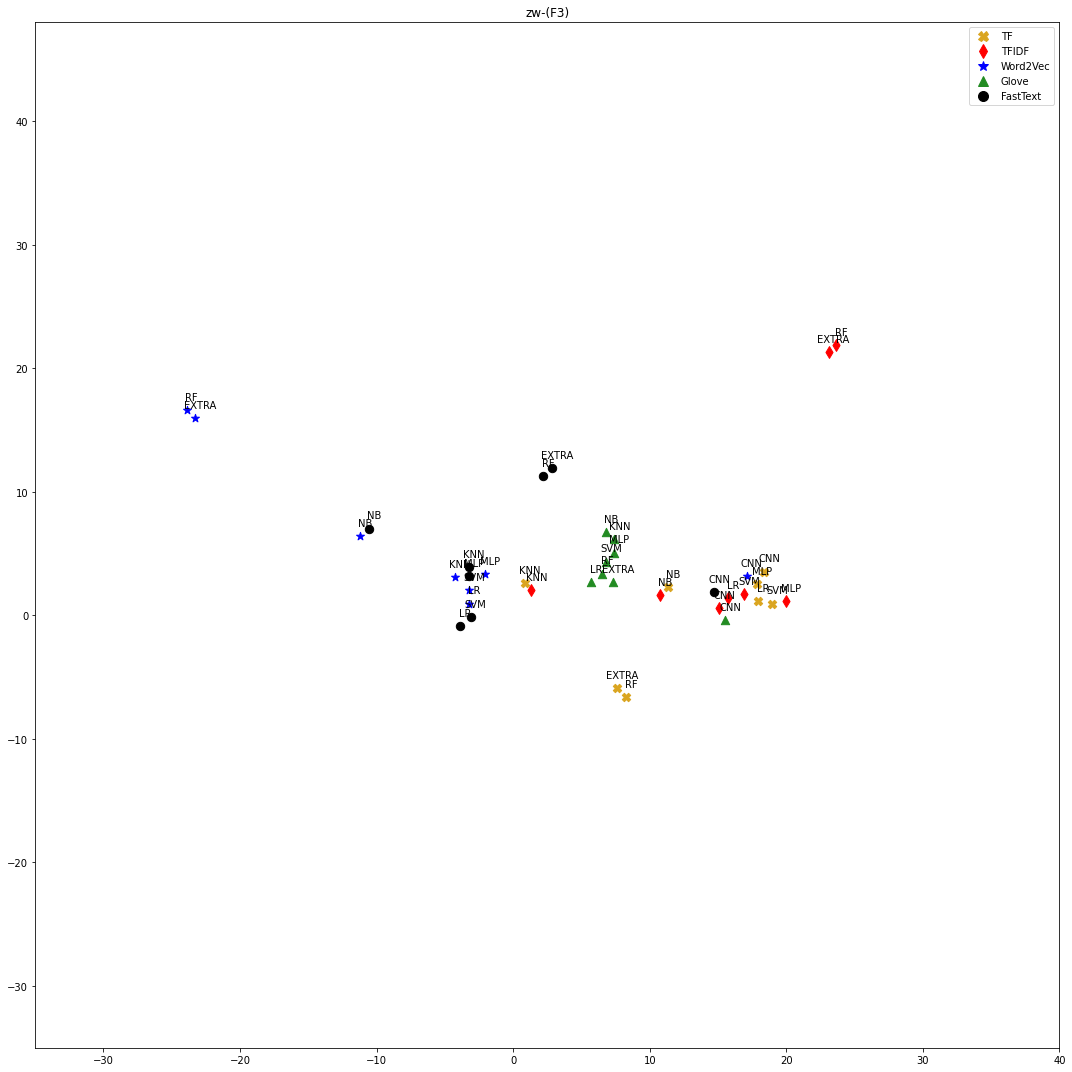

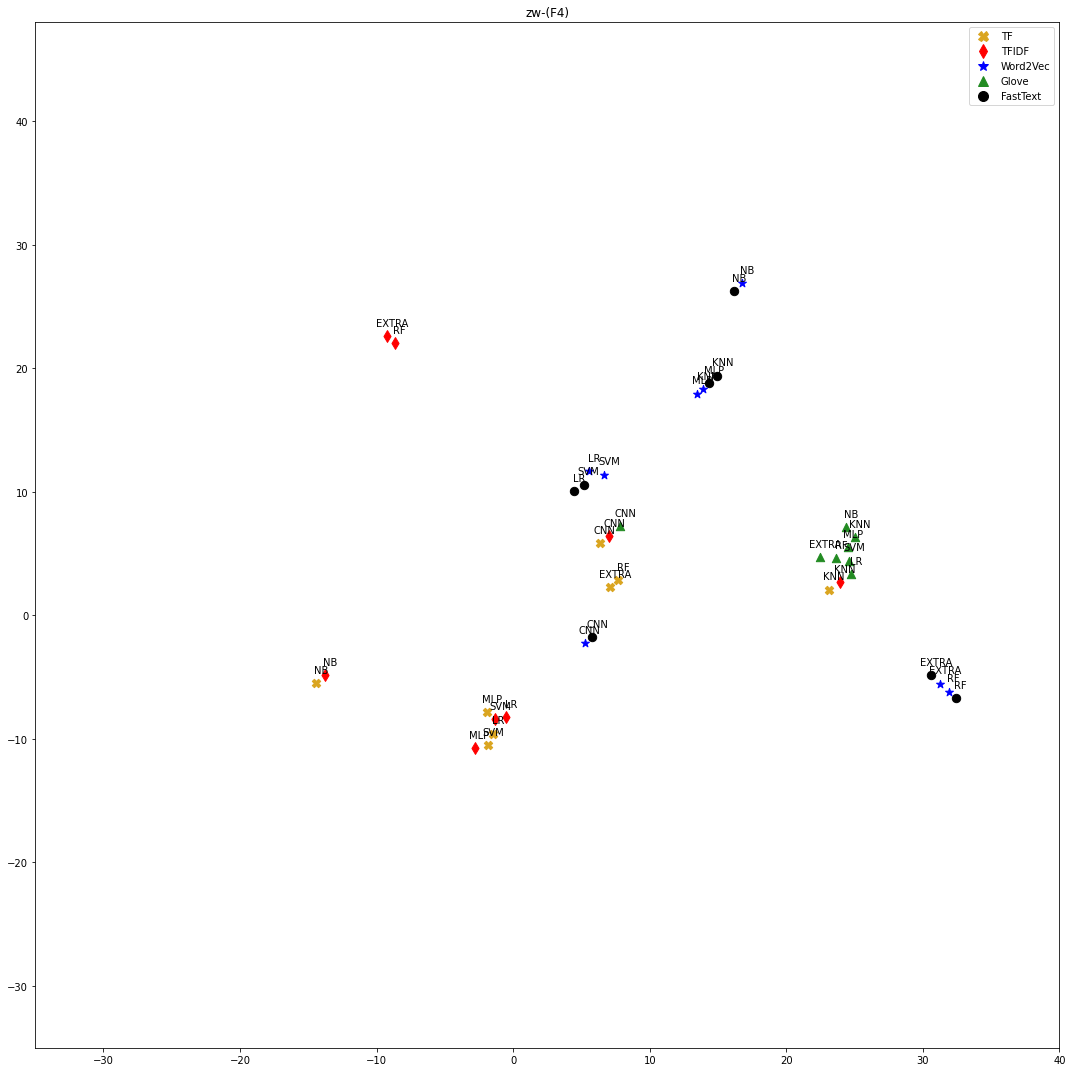

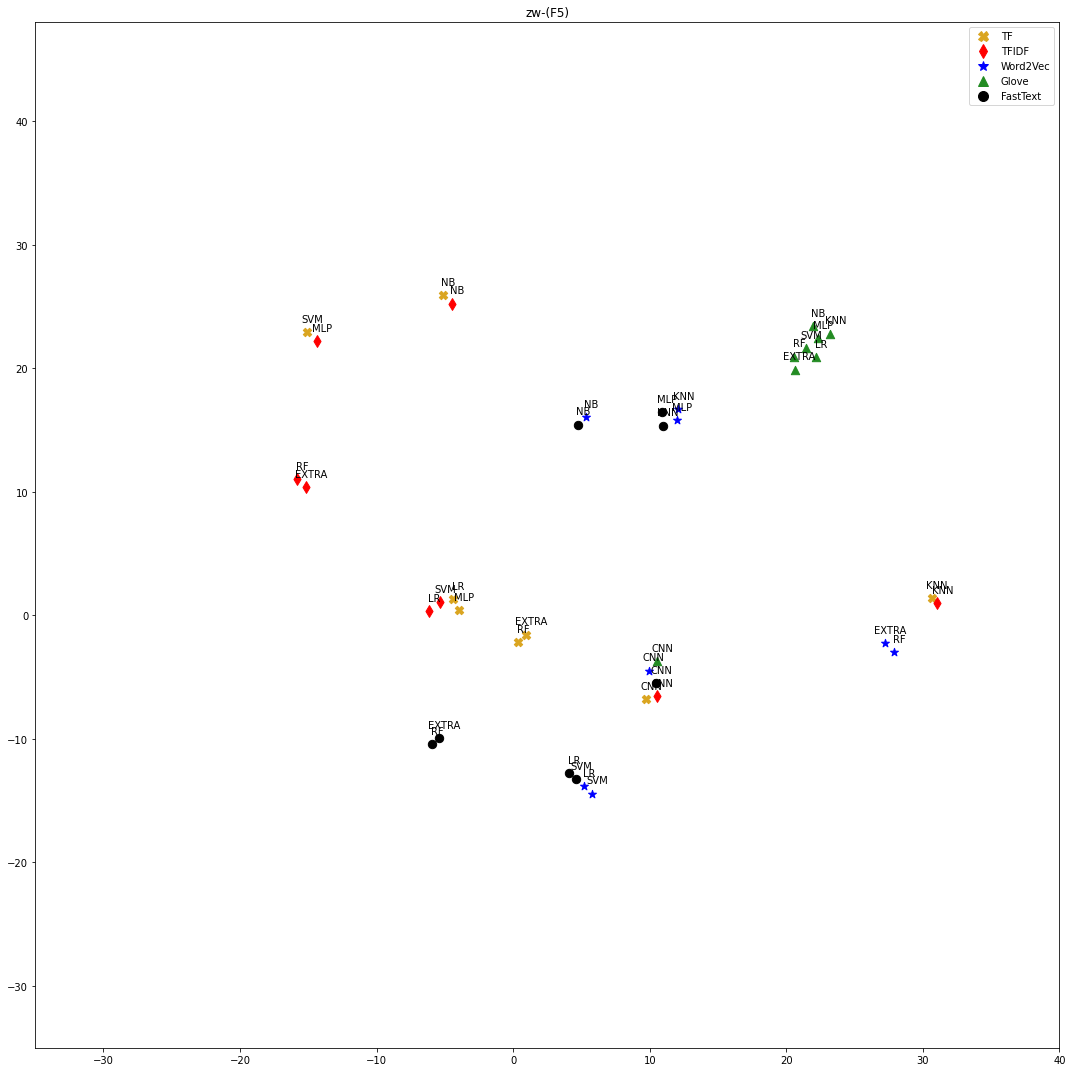

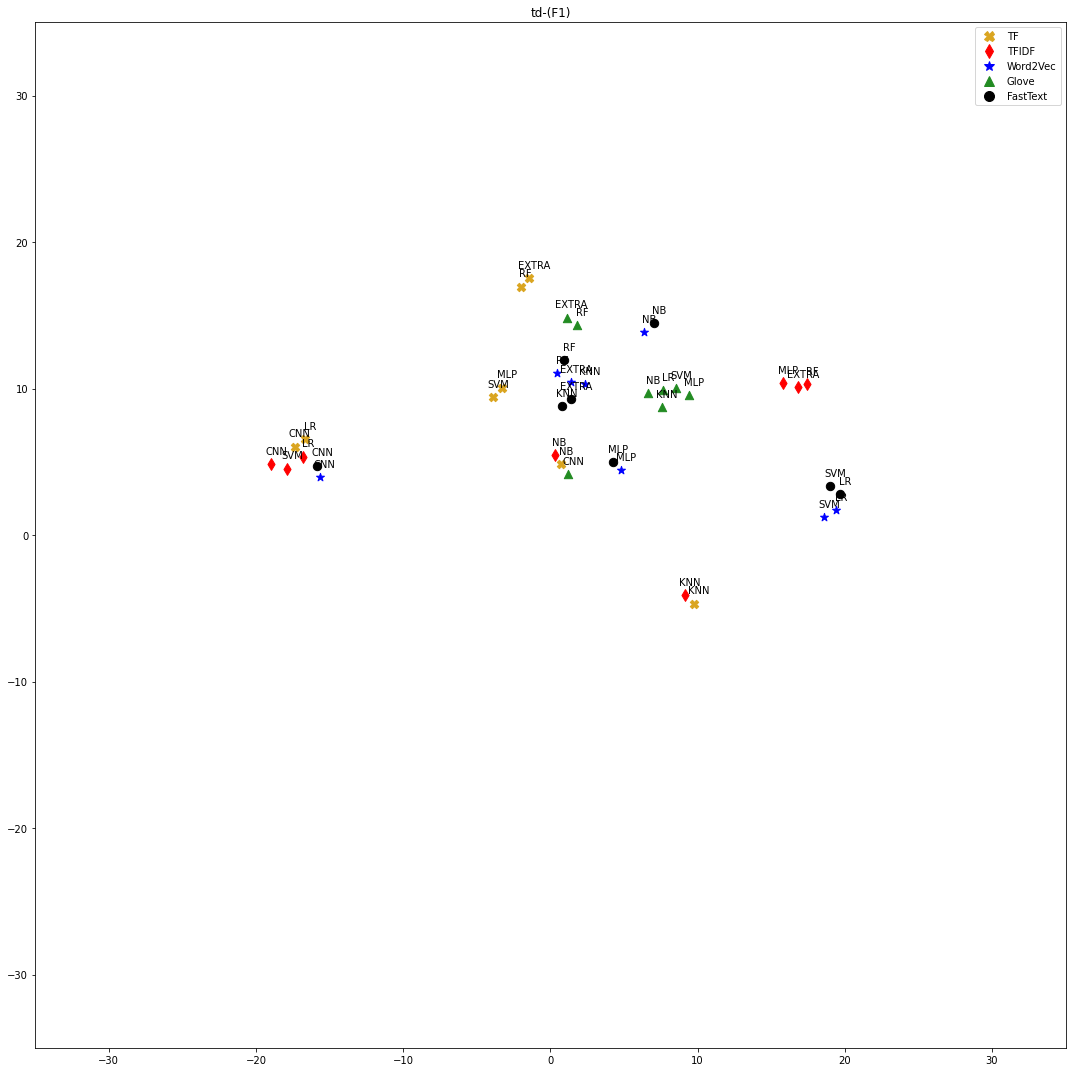

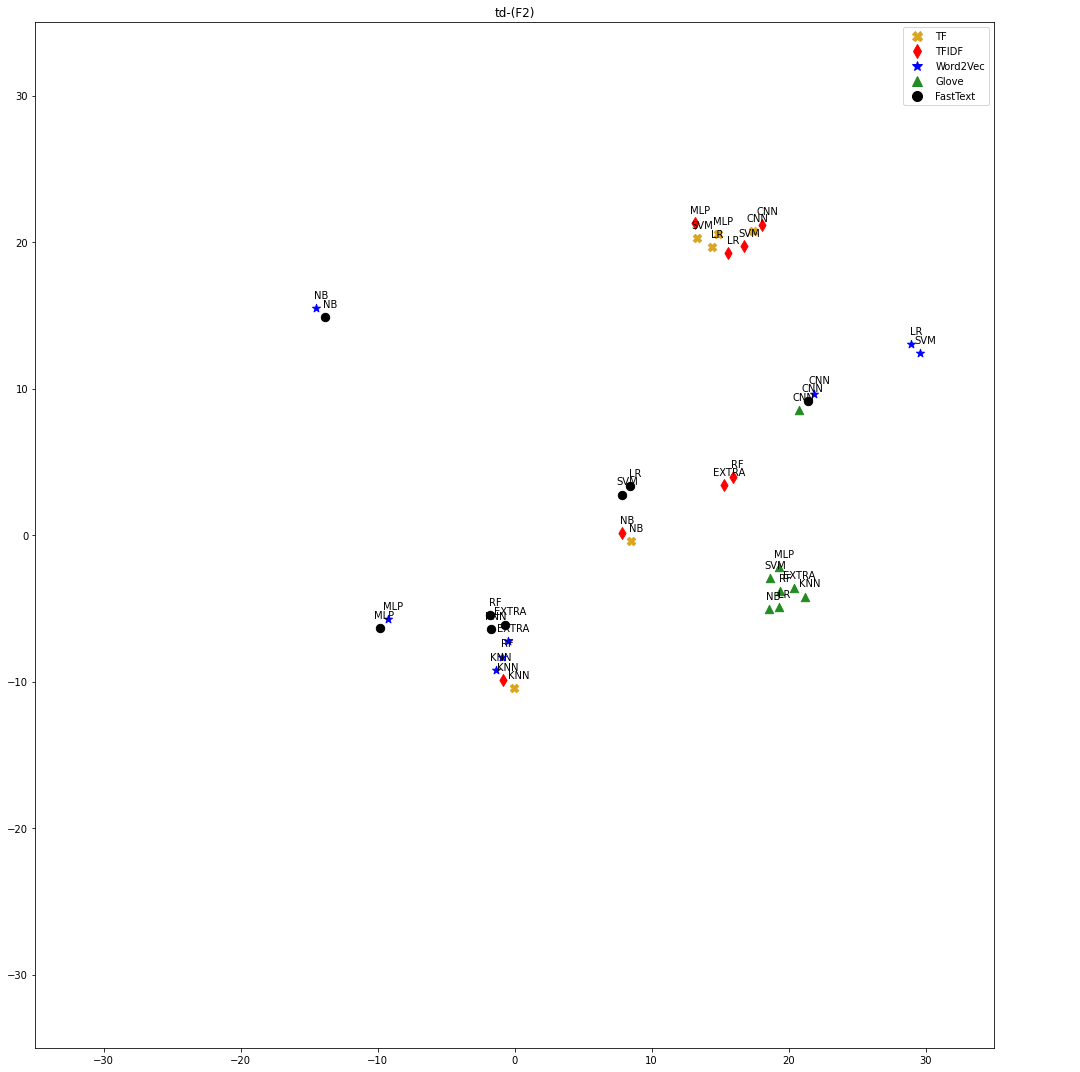

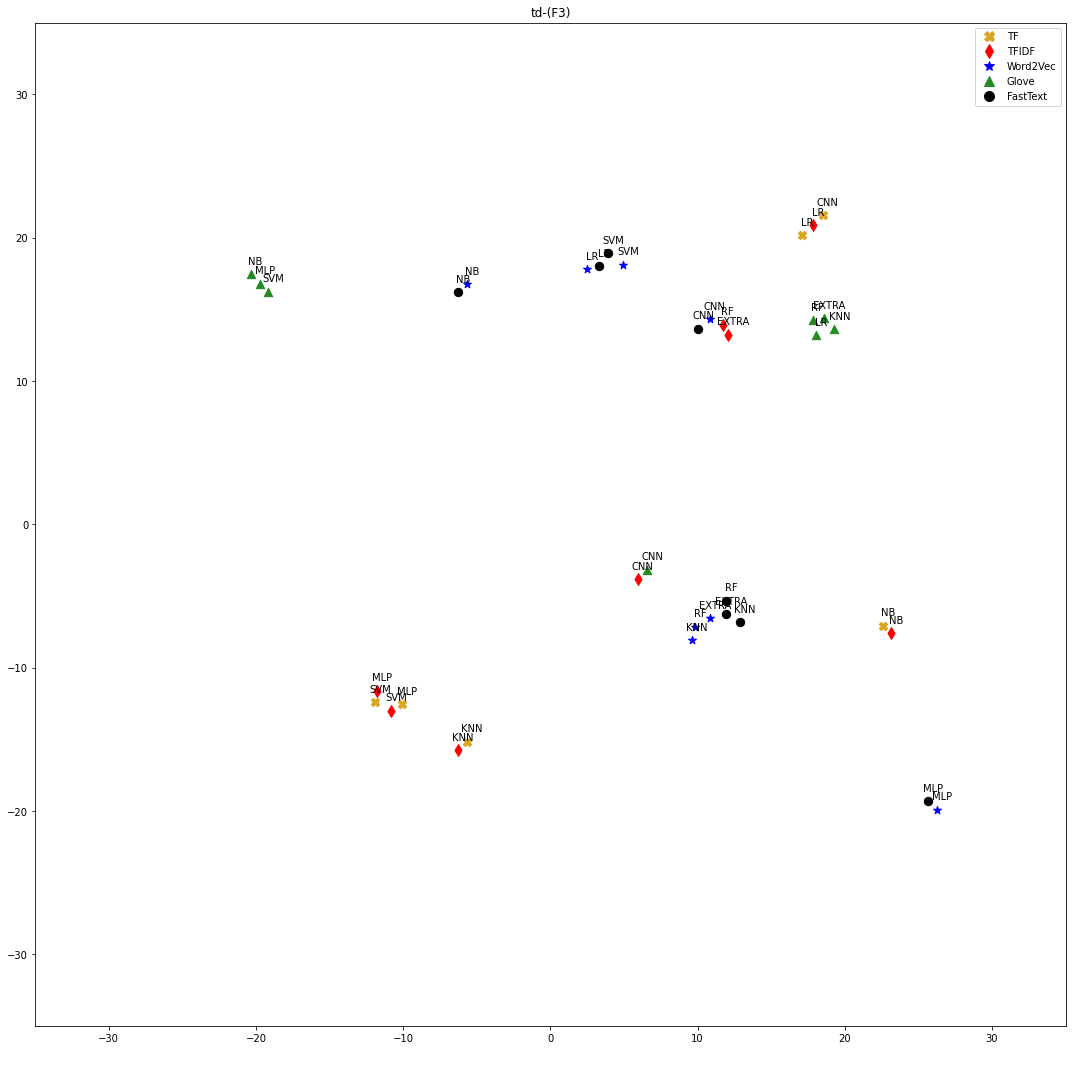

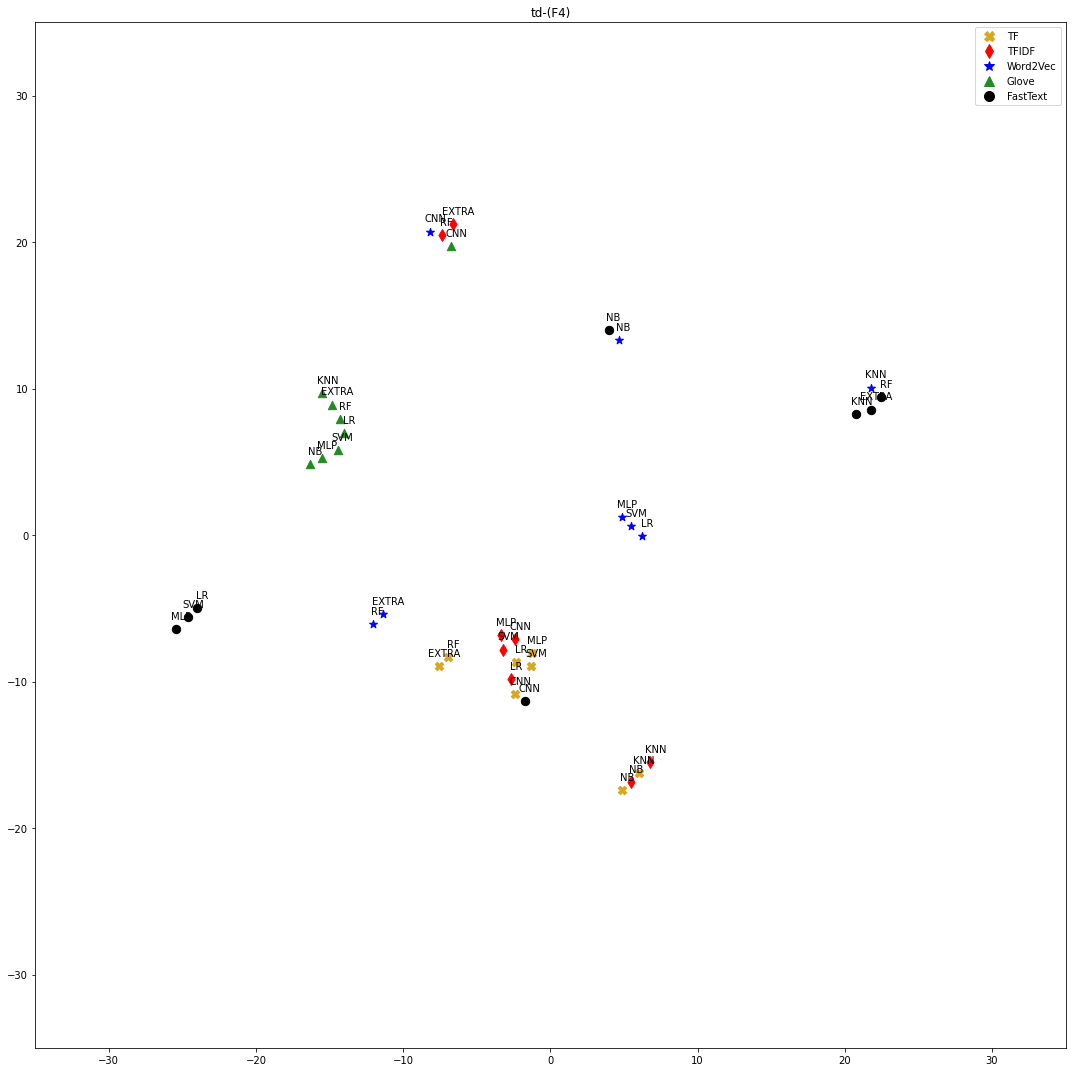

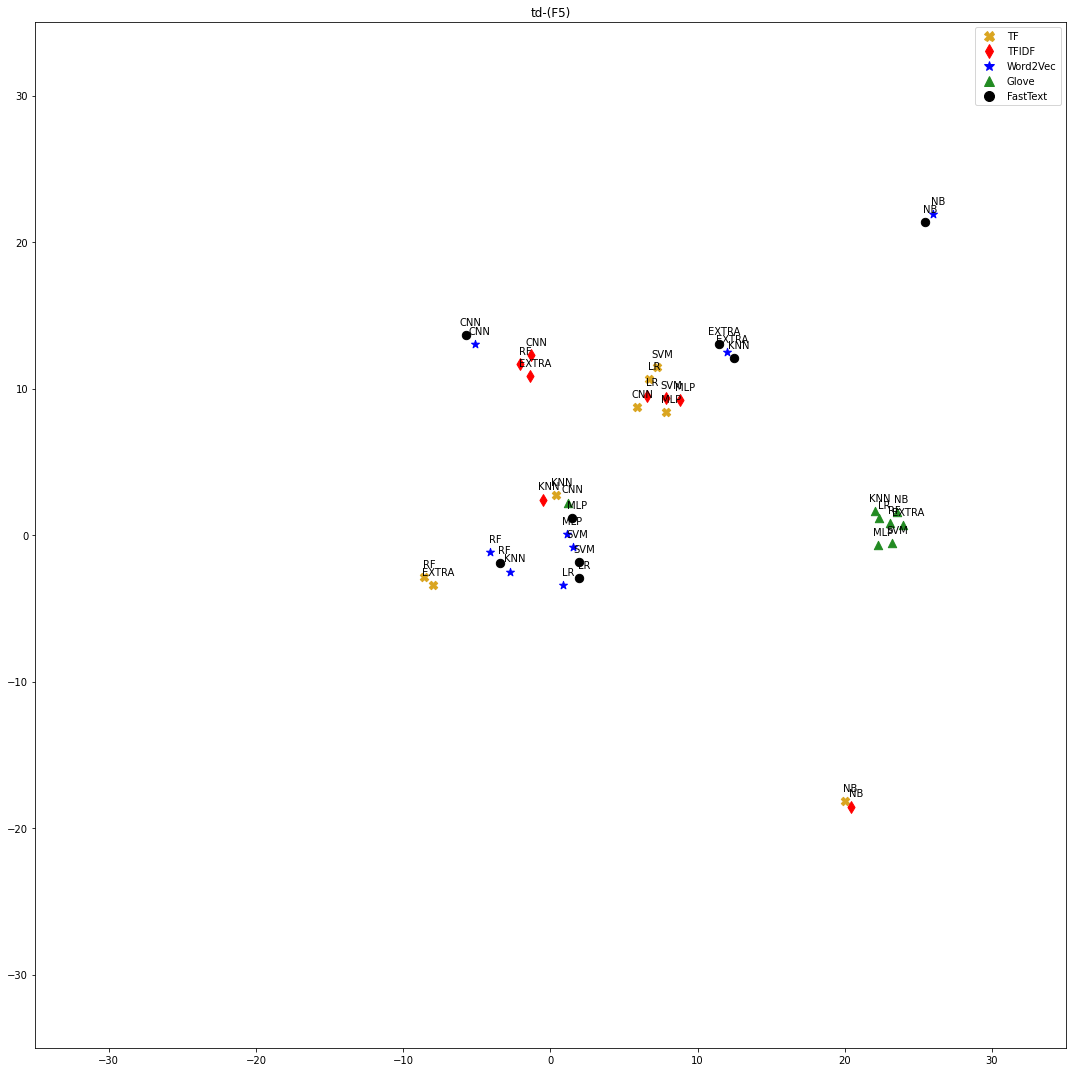

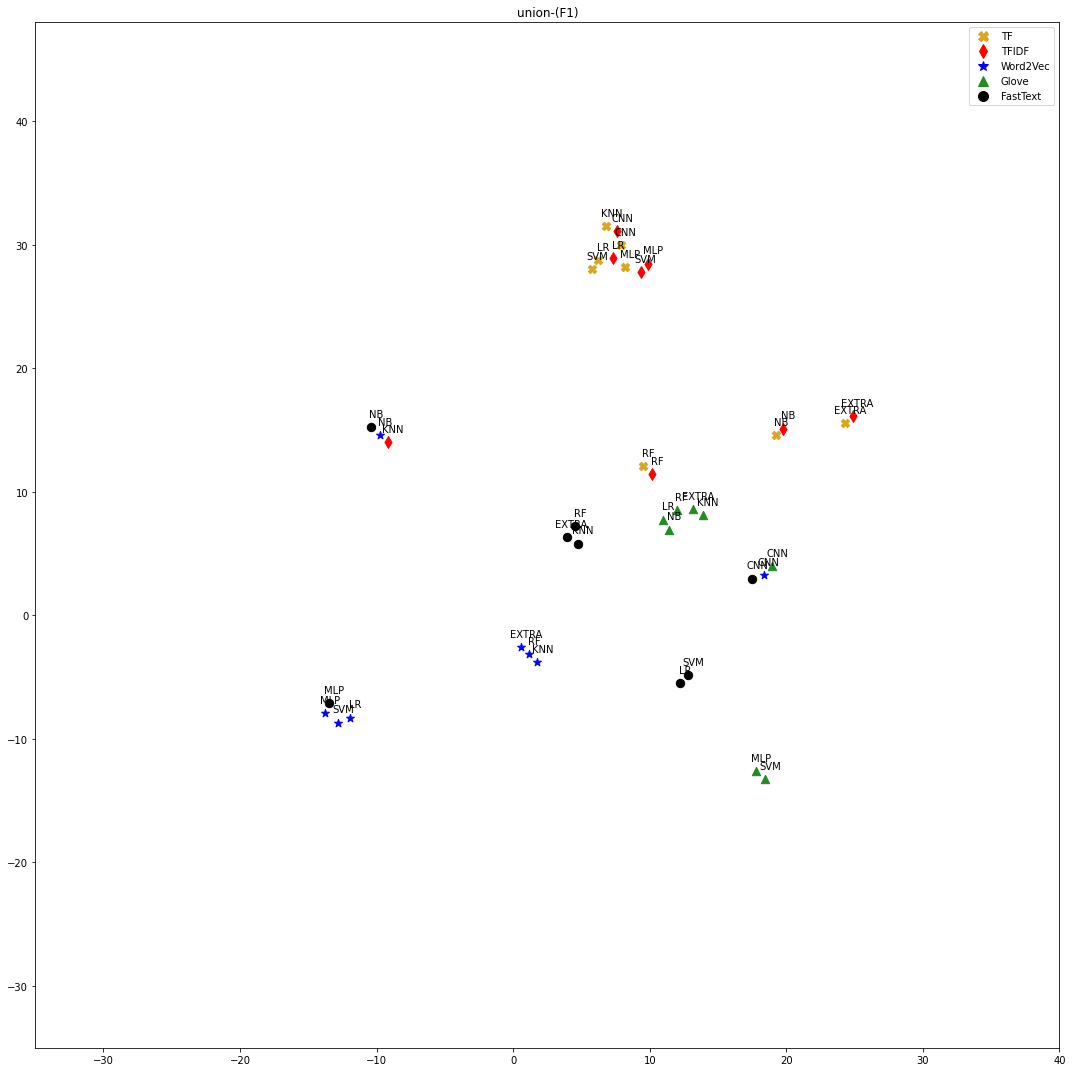

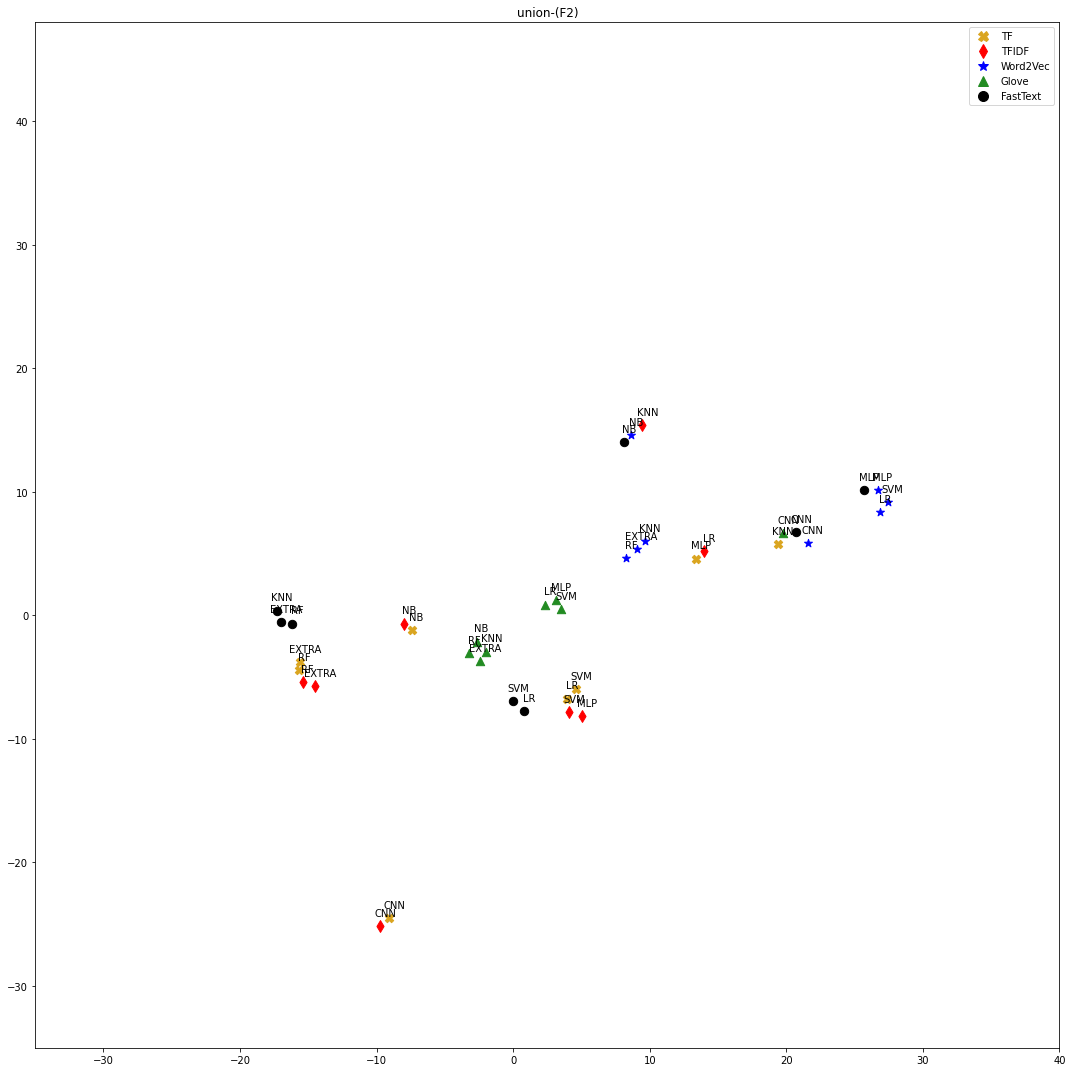

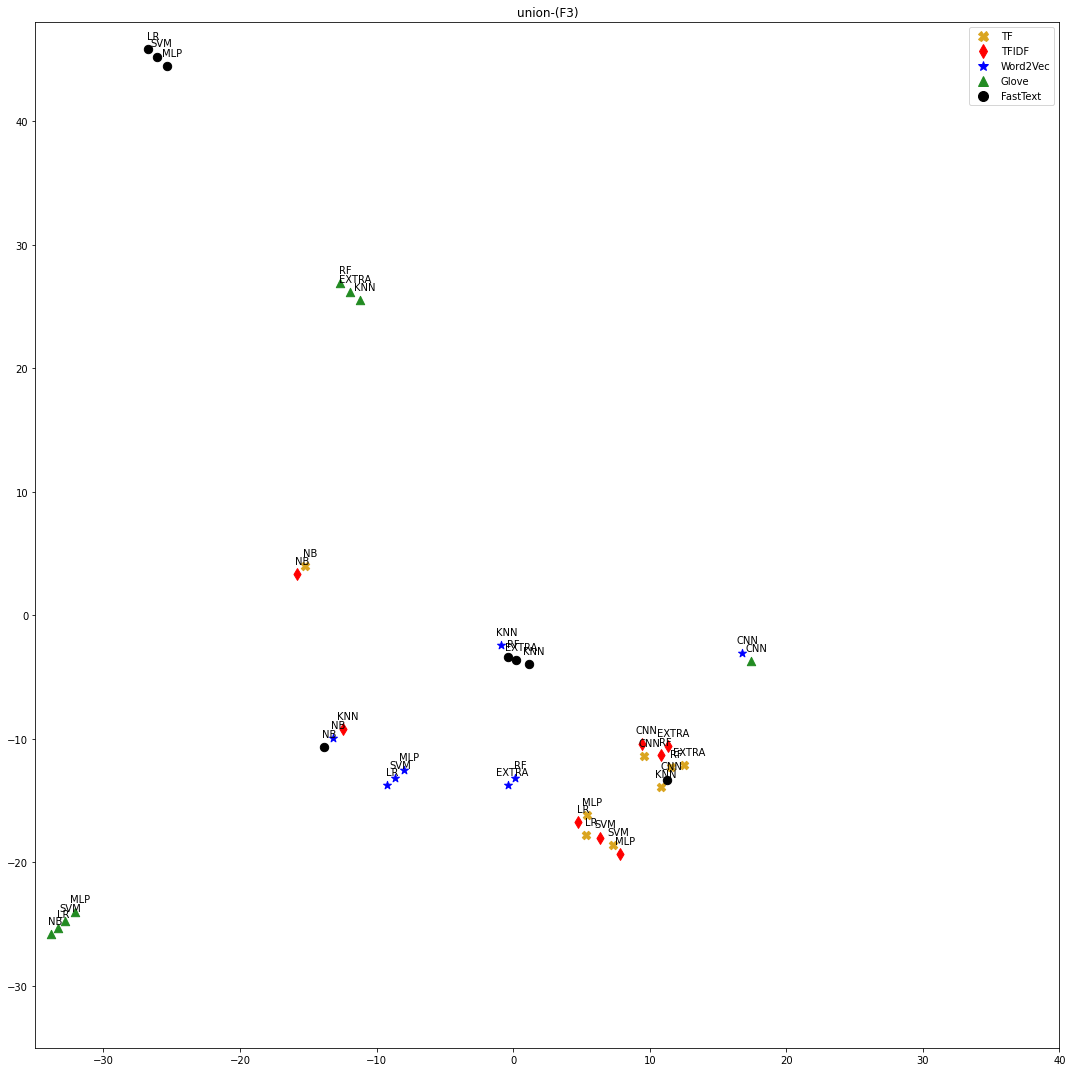

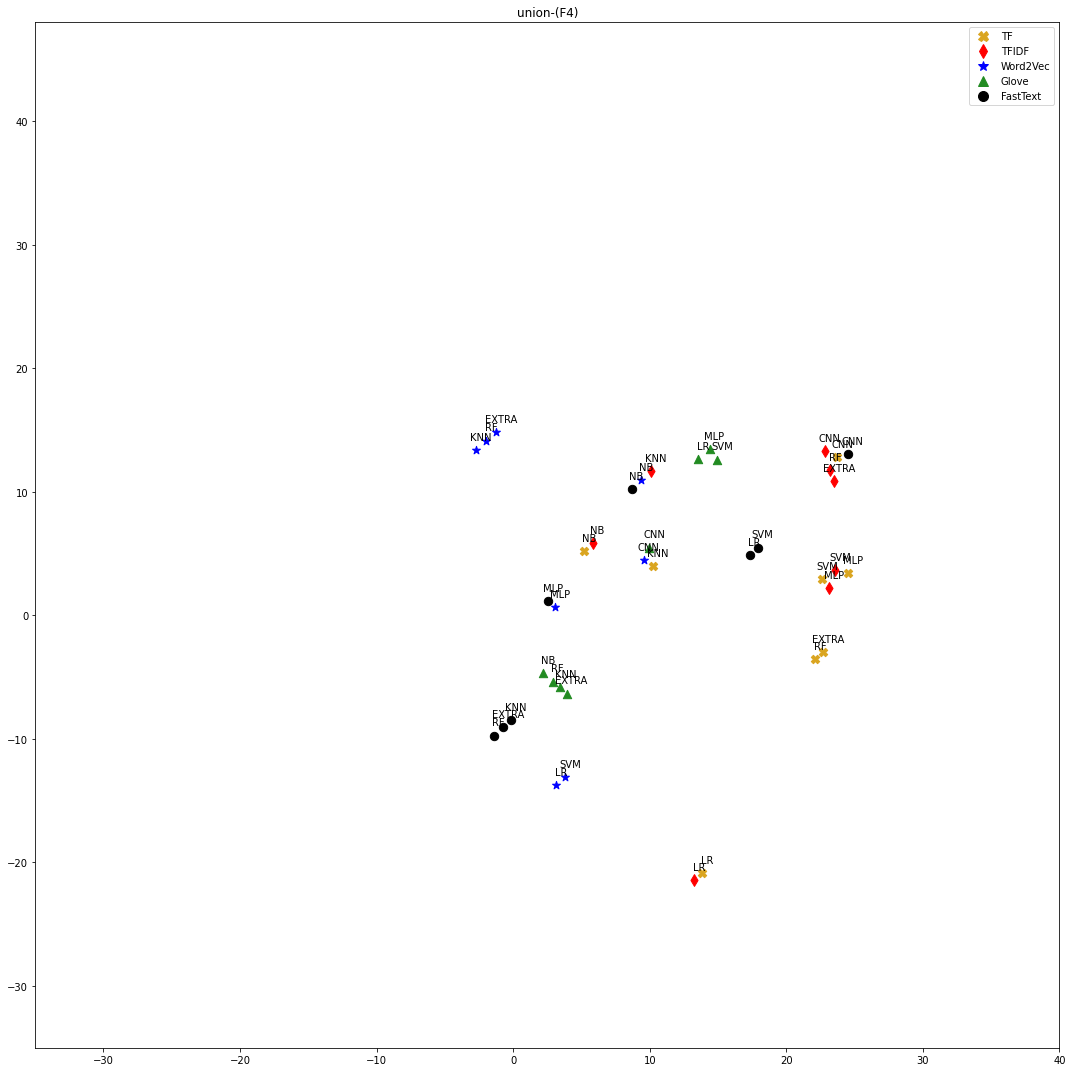

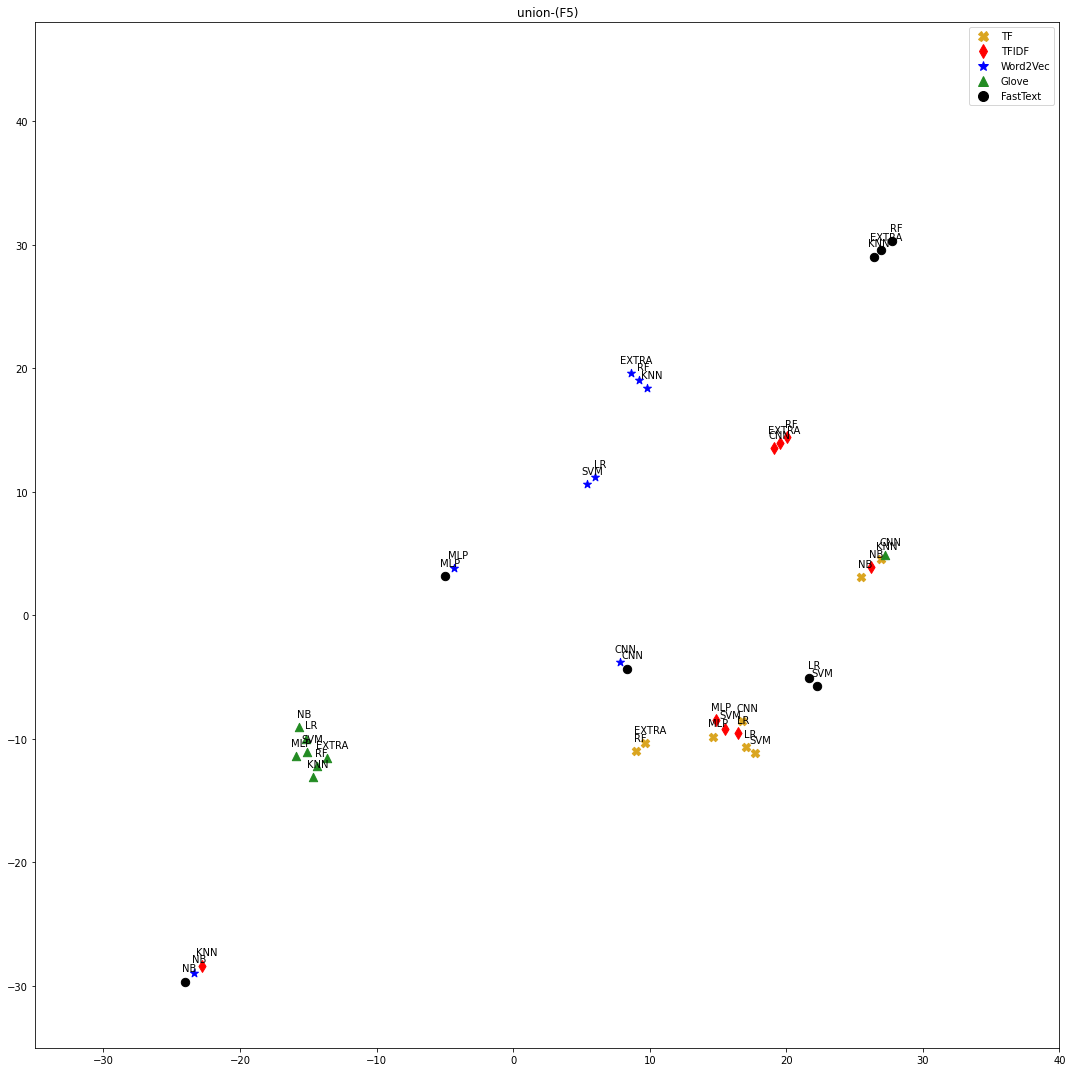

In [ ]:
dataset = ["zw", "td", "union"]
folds = ["F1", "F2", "F3", "F4", "F5"]
for db in dataset:
  for fold in folds:
    val, class_val, test, class_test = load_data(fold, db)    
    delta_double, labels = calc_delta(class_val, val, val.columns, function="d")
    
    if db == "zw":
      tsne_full(labels, delta_double, '{}-({})'.format(db, fold), cores=cores, simbolos=simbolos, escala=0, x_ini=-35, x_fim=40, y_ini=-35, y_fim=48, per=30, size=15 , size_dot=70, tsne=False, neighbors=2)
    elif db == "union":
      tsne_full(labels, delta_double, '{}-({})'.format(db, fold), cores=cores, simbolos=simbolos, escala=0, x_ini=-35, x_fim=40, y_ini=-35, y_fim=48, per=30, size=15 , size_dot=70, tsne=False, neighbors=2)
    else:
      tsne_full(labels, delta_double, '{}-({})'.format(db, fold), cores=cores, simbolos=simbolos, escala=35, per=30, size=15 , size_dot=70, tsne=False, neighbors=2)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


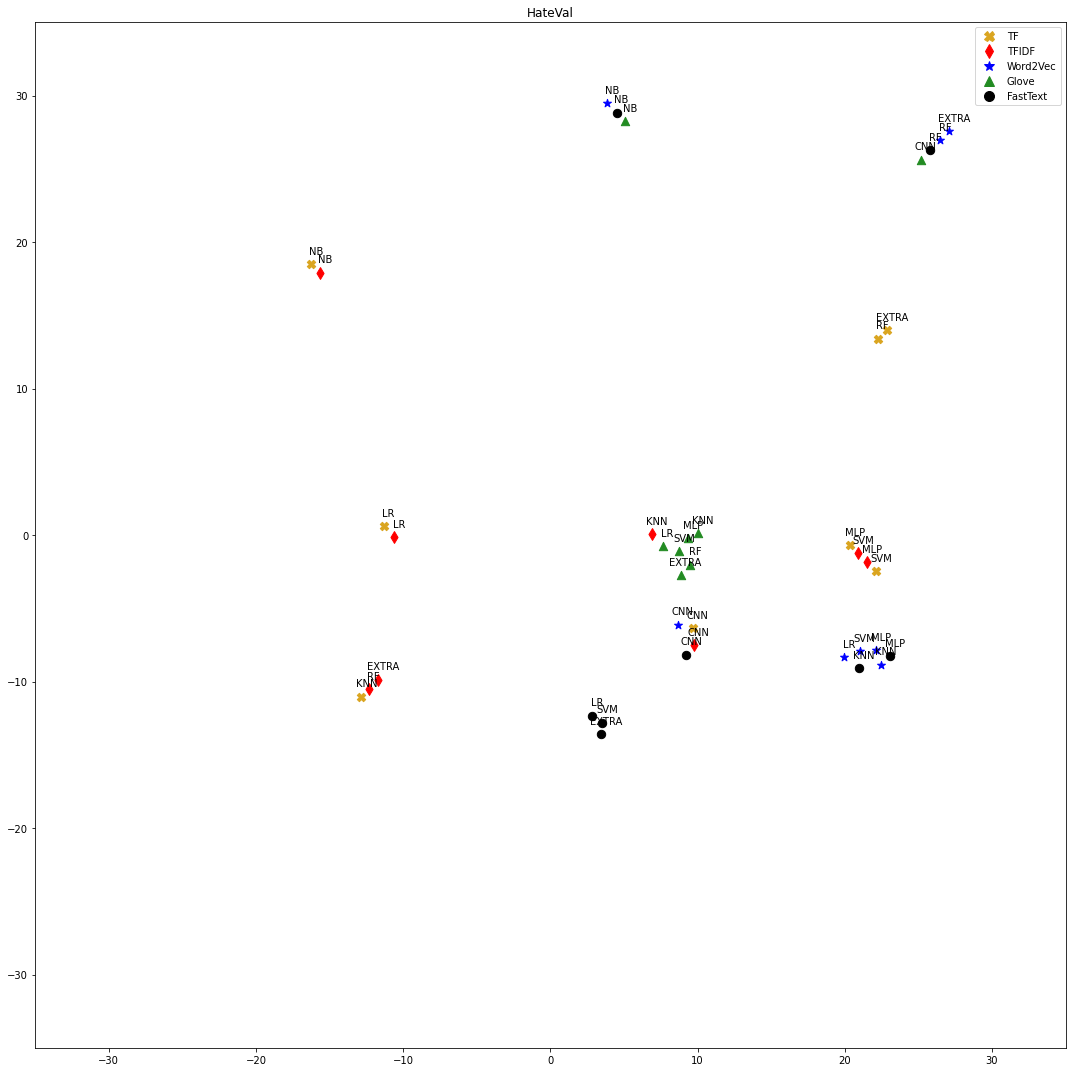

In [ ]:
val, class_val, test, class_test = load_data(None, "hateval")    
delta_double, labels = calc_delta(class_val, val, val.columns, function="d")
# val
tsne_full(labels, delta_double, 'HateVal', cores=cores, simbolos=simbolos, escala=35, per=30, size=15 , size_dot=70, tsne=False, neighbors=2)